## Brain tumor segmentation model

### Initial set-up for utilizing Colab TPU

In [ ]:
# Connect to TPU
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print('Running on TPU:', tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()  # Use default strategy if TPU not available
    print('Running on default strategy')


Running on TPU: 


### Data Preparation

#### Loading the data from kaggle

In [ ]:
# Uploading the kaggle api key from the system

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saumya12345","key":"b62855291cca7b61b5f1b1672ed1c8bd"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Downloading the dataset from kaggle

!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation


Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown
 97% 303M/312M [00:01<00:00, 209MB/s]
100% 312M/312M [00:01<00:00, 237MB/s]


In [ ]:
!ls


brain-tumor-segmentation.zip  sample_data


In [ ]:
# Unziping the downloaded file

import zipfile

with zipfile.ZipFile('brain-tumor-segmentation.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/brain-tumor-segmentation')


In [ ]:
!ls /content/brain-tumor-segmentation


images	masks


#### Converting to numpy array and normalization

In [ ]:
import numpy as np
from PIL import Image
import os

# Define paths to your image and mask directories
image_dir = "/content/brain-tumor-segmentation/images"
mask_dir = "/content/brain-tumor-segmentation/masks"

# List all the PNG files in both directories (assumes the names are the same in both directories)
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

# Set the target size for resizing; done to ensure that all the samples are of same size
target_size = (256, 256)

# Create empty lists to store the arrays
images = []
masks = []

# Load images and masks into numpy arrays
for img_file, mask_file in zip(image_files, mask_files):
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, mask_file)

    # Open the image and mask
    img = Image.open(img_path).convert("L")  # Convert to grayscale
    mask = Image.open(mask_path).convert("L")  # Convert to grayscale

    # Resize both image and mask to the target size
    img = img.resize(target_size)
    mask = mask.resize(target_size)

    # Convert to numpy arrays
    img_array = np.array(img)
    mask_array = np.array(mask)

    # Normalize the images and masks
    img_array = img_array / 255.0
    mask_array = mask_array / 255.0

    # Append to lists
    images.append(img_array)
    masks.append(mask_array)

# Convert the lists to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Print the shapes of the arrays
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)


Images shape: (3064, 256, 256)
Masks shape: (3064, 256, 256)


In [ ]:
def check_masks(masks):
  # Checks if all elements in the masks list are either 0 or 1.
  for mask in masks:
    if not np.isin(mask, [0, 1]).all():
      return False
  return True

# Check your masks list
all_0_or_1 = check_masks(masks)

if all_0_or_1:
  print("All mask elements are either 0 or 1")
else:
  print("Some mask elements are not 0 or 1")

Some mask elements are not 0 or 1


In [ ]:
# Convert non-binary pixels in mask samples to 0 or 1

for i in range(len(masks)):
  masks[i] = np.where(masks[i] > 0, 1, 0)  # Set values > 0 to 1, others to 0

# Now re-check if all elements are 0 or 1
all_0_or_1 = check_masks(masks)
print(all_0_or_1)  # Should now print True

True


#### Display a few examples

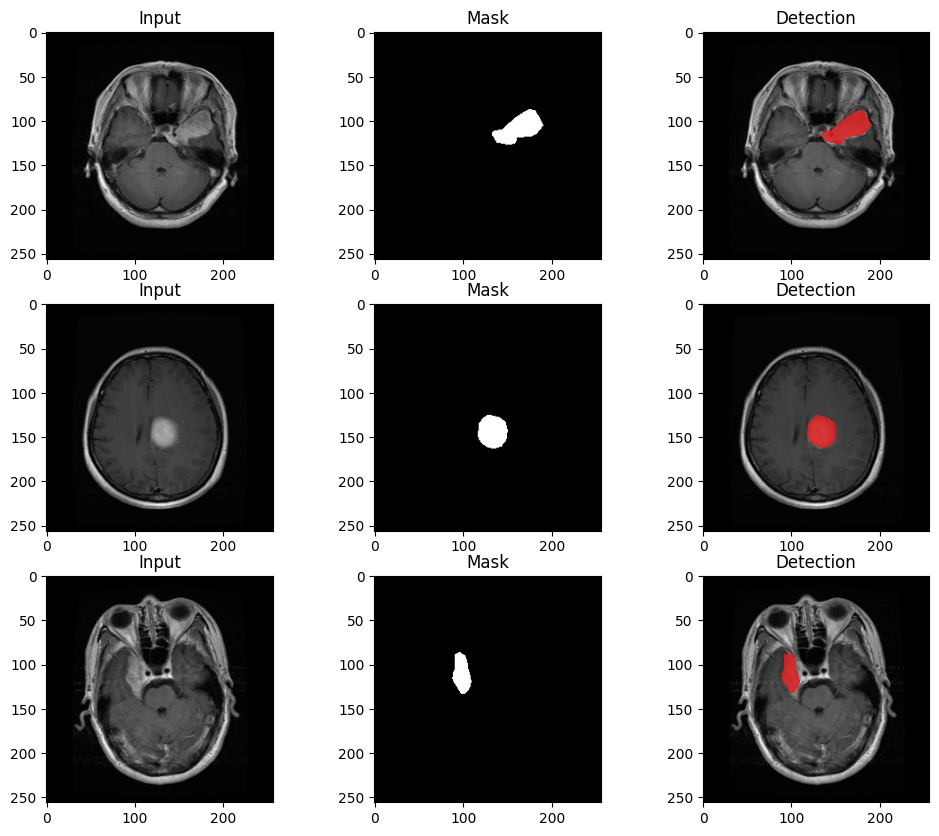

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

plt.subplot(3,3,1)
plt.title('Input')
plt.imshow(images[0,:], cmap = 'gray')

plt.subplot(3,3,2)
plt.title('Mask')
plt.imshow(masks[0,:], cmap = 'gray')

plt.subplot(3,3,3)
plt.title('Detection')
plt.imshow(images[0,:],cmap='gray')
mask = np.ma.masked_where(masks[0] == False, masks[0])
plt.imshow(mask, alpha=0.8, cmap='Set1')

plt.subplot(3,3,4)
plt.title('Input')
plt.imshow(images[1,:], cmap = 'gray')

plt.subplot(3,3,5)
plt.title('Mask')
plt.imshow(masks[1,:], cmap = 'gray')

plt.subplot(3,3,6)
plt.title('Detection')
plt.imshow(images[1,:],cmap='gray')
mask = np.ma.masked_where(masks[1] == False, masks[1])
plt.imshow(mask, alpha=0.8, cmap='Set1')

plt.subplot(3,3,7)
plt.title('Input')
plt.imshow(images[2,:], cmap = 'gray')

plt.subplot(3,3,8)
plt.title('Mask')
plt.imshow(masks[2,:], cmap = 'gray')

plt.subplot(3,3,9)
plt.title('Detection')
plt.imshow(images[2,:],cmap='gray')
mask = np.ma.masked_where(masks[2] == False, masks[2])
plt.imshow(mask, alpha=0.8, cmap='Set1')

#### Split into train, test and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

# Define the split ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Initialize lists to store the split data
train_images, train_masks = [], []
val_images, val_masks = [], []
test_images, test_masks = [], []



# Split into train, validation, and test for the current batch

# 1. Split into train and test set
X_temp, X_test, mask_temp, mask_test = train_test_split(
        images, masks, test_size=test_ratio, random_state=42
    )

# 2. Split the test set into test and validation set
X_train, X_val, mask_train, mask_val = train_test_split(
        X_temp, mask_temp, test_size=val_ratio / (train_ratio + val_ratio), random_state=42
    )





In [ ]:
# delete earlier lists to free up some memory

del images
del masks

In [ ]:
del image_files
del mask_files

In [ ]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1838
Validation set size: 613
Test set size: 613


#### Resizing the data so that channel information is also captured

In [ ]:
# Resizing the data so that channel information is also captured
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

mask_train = mask_train.reshape(mask_train.shape[0], mask_train.shape[1], mask_train.shape[2], 1)
mask_test = mask_test.reshape(mask_test.shape[0], mask_test.shape[1], mask_test.shape[2], 1)

X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
mask_val = mask_val.reshape(mask_val.shape[0], mask_val.shape[1], mask_val.shape[2], 1)


# Verifying the shapes
print(X_train.shape)
print(mask_train.shape)
print('\n')
print(X_test.shape)
print(mask_test.shape)
print('\n')
print(X_val.shape)
print(mask_val.shape)

(1838, 256, 256, 1)
(1838, 256, 256, 1)


(613, 256, 256, 1)
(613, 256, 256, 1)


(613, 256, 256, 1)
(613, 256, 256, 1)


In [ ]:
# Delete earlier lists to free up memory

del X_temp
del mask_temp

#### Convert to Tensorflow datasets

We have applied horizontal flip as the augmentation transformation randomly for 50% of the training dataset

In [ ]:
import tensorflow as tf

def augment(image, mask):
    # Apply the same random decision to both image and mask
    if tf.random.uniform(()) > 0.5:  # Randomly decide to flip or not
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    return image, mask


In [ ]:
# Creating a custom Tensorflow dataset
import tensorflow as tf

train_data = tf.data.Dataset.from_tensor_slices((X_train, mask_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, mask_test))
val_data = tf.data.Dataset.from_tensor_slices((X_val, mask_val))

BATCH_SIZE = 8

train_data = train_data.shuffle(buffer_size=1000)
train_data = train_data.batch(BATCH_SIZE,drop_remainder=True)
train_datat = train_data.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

val_data = val_data.batch(BATCH_SIZE)
val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)



In [ ]:
# delete earlier lists to free up some memory

del X_train
del mask_train
del X_test
del mask_test
del X_val
del mask_val

#### Visualize few train_data samples


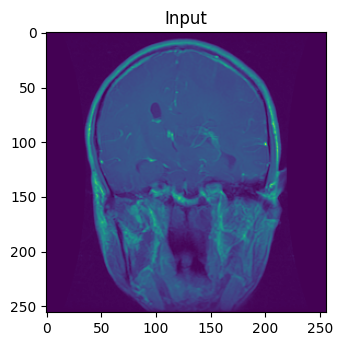

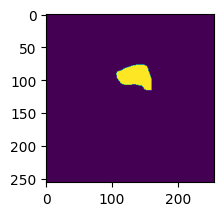

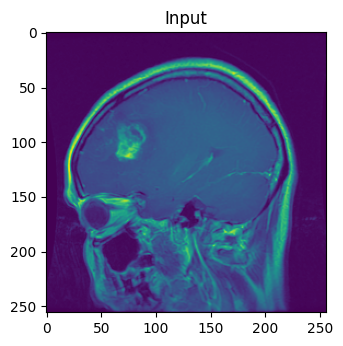

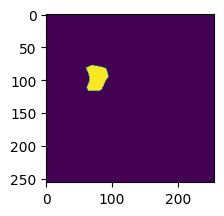

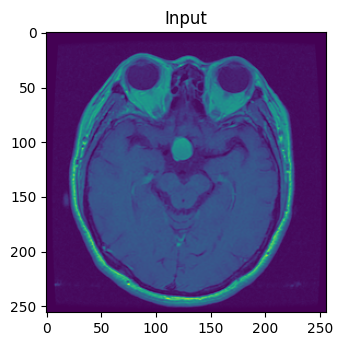

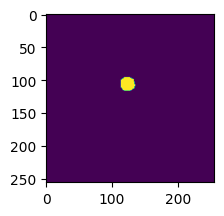

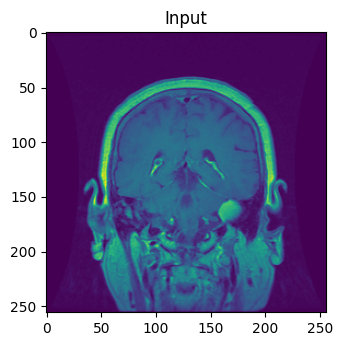

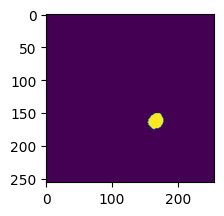

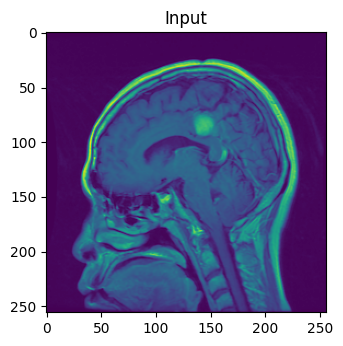

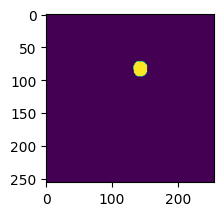

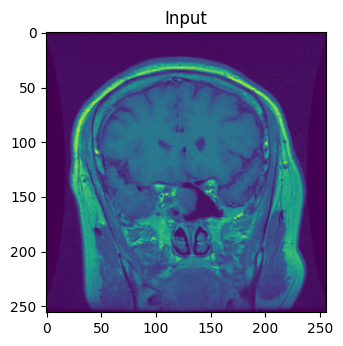

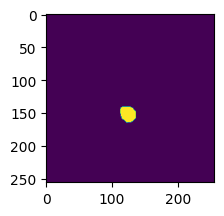

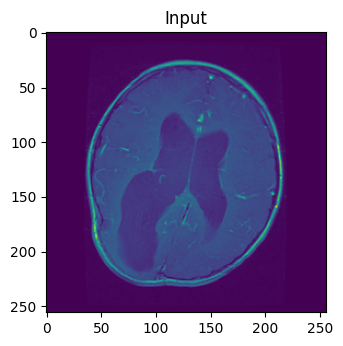

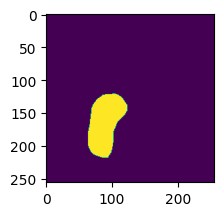

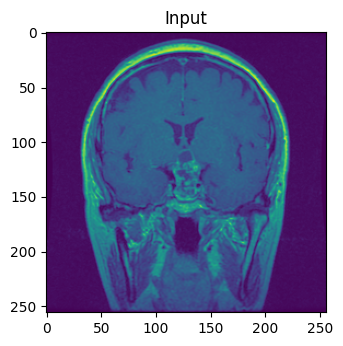

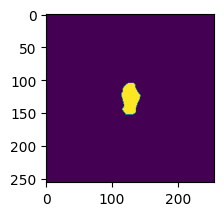

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

for images, masks in train_data.take(1):
  # Iterate through the batch and display each image individually
  for i in range(images.shape[0]):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 2, 1)
    plt.title('Input')
    plt.imshow(images[i])  # Display the i-th image in the batch
    plt.show()
    # Optionally, display the corresponding mask
    plt.subplot(2, 2, 2)
    plt.imshow(masks[i])
    plt.show()

### Building and Training the model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [ ]:
def build_unet_model():
 # inputs
   inputs = layers.Input(shape=(256,256,1))

   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
  #  # 4 - downsample
   f4, p4 = downsample_block(p3, 512)

   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)

   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
  #  8 - upsample
   u8 = upsample_block(u7, f2, 128)
  #  # 9 - upsample
   u9 = upsample_block(u8, f1, 64)

   # outputs
   outputs = layers.Conv2D(1, 1, padding="same",  activation="sigmoid")(u9)

   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

   return unet_model

In [ ]:
# build the U-Net model

unet_model = build_unet_model()

In [ ]:
# Get the model summary printed

unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
# install keras-cv for focal loss

!pip install keras-cv
import keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 35.9 MB/s eta 0:00:00
Using TensorFlow backend


In [ ]:
with strategy.scope():
  # Re-build the model inside the strategy scope to use Colab TPU
  unet_model = build_unet_model() # Moved inside strategy.scope()

  # Compiling the model within strategy.scope()
  unet_model.compile(loss=keras_cv.losses.FocalLoss(),
                optimizer=tf.keras.optimizers.Adam(1e-4),
                metrics = ['acc'])

# Training the model
  history = unet_model.fit(train_data,epochs = 200, validation_data = val_data)

Epoch 1/200
229/229 [==============================] - 67s 137ms/step - loss: 0.0101 - acc: 0.9804 - val_loss: 0.0279 - val_acc: 0.9813
Epoch 2/200
229/229 [==============================] - 21s 90ms/step - loss: 0.0066 - acc: 0.9818 - val_loss: 0.0159 - val_acc: 0.9816
Epoch 3/200
229/229 [==============================] - 20s 89ms/step - loss: 0.0058 - acc: 0.9819 - val_loss: 0.0094 - val_acc: 0.9800
Epoch 4/200
229/229 [==============================] - 20s 88ms/step - loss: 0.0053 - acc: 0.9830 - val_loss: 0.0059 - val_acc: 0.9840
Epoch 5/200
229/229 [==============================] - 20s 89ms/step - loss: 0.0045 - acc: 0.9845 - val_loss: 0.0051 - val_acc: 0.9848
Epoch 6/200
229/229 [==============================] - 21s 90ms/step - loss: 0.0040 - acc: 0.9858 - val_loss: 0.0044 - val_acc: 0.9867
Epoch 7/200
229/229 [==============================] - 21s 90ms/step - loss: 0.0036 - acc: 0.9868 - val_loss: 0.0041 - val_acc: 0.9870
Epoch 8/200
229/229 [==============================] -

In [ ]:
# Defining a function to extract history from the model and plot the metrics as graphs

def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

### Evaluation of model performance

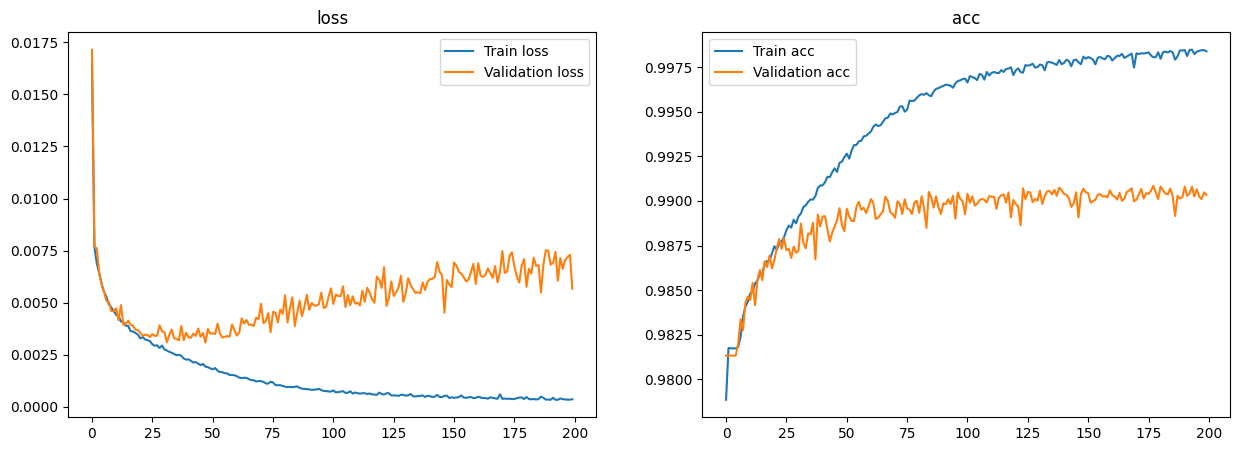

In [ ]:
# Plotting the graphs of variation of training metrics over epochs

show_history(history)

#### Evaluating model performance on test dataset

In [ ]:
# Get the image, mask data from test tensorflow dataset

# Initialize lists to store images and ground truth masks
all_images = []
all_masks = []

# Iterate through the dataset
for images, masks in test_data:
    all_images.append(images.numpy())  # Convert images to NumPy
    all_masks.append(masks.numpy())   # Convert masks to NumPy

# Flatten the lists to get all images and masks
all_images = np.concatenate(all_images, axis=0)
all_masks = np.concatenate(all_masks, axis=0)

print(f'Total Images: {all_images.shape}')
print(f'Total Masks: {all_masks.shape}')

Total Images: (613, 256, 256, 1)
Total Masks: (613, 256, 256, 1)


##### Model accuracy and loss over test dataset

In [ ]:
# Evaluate the model on the test dataset and print out the accuracy and loss
test_loss, test_accuracy = unet_model.evaluate(test_data)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

77/77 [==============================] - 4s 32ms/step - loss: 0.0052 - acc: 0.9910
Test Loss: 0.0052
Test Accuracy: 0.9910


##### Obtaining mean IoU, mean dice coefficient, precision and recall over test dataset

In [ ]:
# IoU Metric Function
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)  # Ensure the ground truth is float32
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Apply threshold to predictions
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

# Compute IoU for the test dataset
iou_scores = []

for images, masks in test_data:
    predictions = unet_model.predict(images)  # Get model predictions
    iou = iou_metric(masks, predictions)  # Calculate IoU
    iou_scores.append(iou.numpy())  # Convert to NumPy and store

# Calculate mean IoU across the test dataset
mean_iou = sum(iou_scores) / len(iou_scores)
print(f'Mean IoU: {mean_iou:.4f}')


1/1 [==============================] - 0s 462ms/step
Mean IoU: 0.5519


In [ ]:
# Get predictions for the entire dataset
predictions = unet_model.predict(all_images)
predictions = (predictions > 0.5).astype(np.float32)  # Threshold predictions

# Metric functions
def precision(y_true, y_pred):
    true_positive = np.sum(y_true * y_pred)
    predicted_positive = np.sum(y_pred)
    return true_positive / (predicted_positive + 1e-6)

def recall(y_true, y_pred):
    true_positive = np.sum(y_true * y_pred)
    actual_positive = np.sum(y_true)
    return true_positive / (actual_positive + 1e-6)

# Compute precision and recall
test_precision = precision(all_masks, predictions)
test_recall = recall(all_masks, predictions)

print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')


20/20 [==============================] - 17s 379ms/step
Test Precision: 0.8934
Test Recall: 0.5856


In [ ]:
# Dice coefficient function
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Calculate Dice coefficient for two binary masks.
    Args:
        y_true (numpy array): Ground truth mask.
        y_pred (numpy array): Predicted mask.
        smooth (float): Smoothing factor to prevent division by zero.
    Returns:
        float: Dice coefficient.
    """
    intersection = np.sum(y_true * y_pred)
    sum_masks = np.sum(y_true) + np.sum(y_pred)
    dice = (2. * intersection + smooth) / (sum_masks + smooth)
    return dice

# Get predictions for all test images
predictions = unet_model.predict(all_images)
predictions = (predictions > 0.5).astype(np.float32)  # Apply threshold to get binary masks

# Calculate Dice coefficients for each sample
dice_scores = [dice_coefficient(all_masks[i], predictions[i]) for i in range(len(all_masks))]

# Compute the mean Dice coefficient across the test dataset
mean_dice = np.mean(dice_scores)

print(f'Mean Dice Coefficient: {mean_dice:.4f}')


20/20 [==============================] - 1s 34ms/step
Mean Dice Coefficient: 0.6714


### Saving weights

In [ ]:
model.save_weights('unet_weights.h5')
print("Weights saved to .h5 file.")


In [ ]:
# Testing to see if the trained weights can be loaded
model.load_weights('unet_weights.h5')
